# NLP Sentiment Analysis

Perform sentiment analysis using Python's NLTK (Natural Language Toolkit) library.

Use the `movie_reviews` corpus, which contains 2,000 movie reviews pre-labeled as either "positive" or "negative."

Compare results for a **Naive Bayes classifier** against results from a **Support Vector Machine (SVM)** classifier.

### Data Preprocessing and Feature Extraction

In [20]:
# Import modules
import nltk
from nltk.corpus import stopwords
from nltk import bigrams, trigrams
from nltk.stem import WordNetLemmatizer
import string

# # Download data and tokenizer, if needed
# nltk.download('movie_reviews')
# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('wordnet')

# Load the movie_reviews corpus
from nltk.corpus import movie_reviews

# Create 'documents' as a list of (review, sentiment) tuples
documents = []
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        # Add a tuple of (list_of_words, category)
        documents.append((list(movie_reviews.words(fileid)), category))

# Process documents to include words, bigrams, and trigrams
# Bigrams (2-word phrases) and trigrams (3-word phrases) capture context
# Example: "not good" as bigram, "not very good" as trigram
processed_documents = []
stop_words = set(stopwords.words('english'))

# Keep sentiment-critical stop words (e.g. negation), removing them from stop_words set
sentiment_words = {
    'not', 'no', 'nor', 'never', 'neither', 'none', 
    'nobody', 'nothing','but', 'however', 'yet', 'although',
    'though', 'very', 'too', 'so', 'such', 'quite'
}
stop_words = stop_words - sentiment_words

# Initialize lemmatizer to reduce words to their base form
# Lemmatization groups related words: "amazing", "amazingly", "amazed" → "amaze"
# This reduces feature sparsity and improves generalization
lemmatizer = WordNetLemmatizer()

# Loop through each document to process words, bigrams, and trigrams
for w_list, category in documents:
    # Convert to lowercase, lemmatize, remove stopwords and punctuation
    # Lemmatization happens AFTER lowercasing for consistency
    clean_words = [lemmatizer.lemmatize(w.lower()) for w in w_list 
                   if w.lower() not in stop_words 
                   and w.lower() not in string.punctuation]
    
    # Create bigrams (2-word combinations) to capture phrases like "not_good"
    # Bigrams help the model understand that "not good" has negative sentiment
    doc_bigrams = [f"{w1}_{w2}" for w1, w2 in bigrams(clean_words)]
    
    # Create trigrams (3-word combinations) to capture longer phrases like "not_very_good"
    # Trigrams provide even more context than bigrams for nuanced sentiment
    doc_trigrams = [f"{w1}_{w2}_{w3}" for w1, w2, w3 in trigrams(clean_words)]
    
    # Combine individual words, bigrams, and trigrams into a single feature list
    processed_documents.append((clean_words + doc_bigrams + doc_trigrams, category))

# Confirm documents were processed successfully
print(f"Successfully processed {len(processed_documents)} documents with words, bigrams, and trigrams.")

# Display an example processed document
print("Example processed document (first 20 tokens):")
print(processed_documents[0][0][:20], processed_documents[0][1])

Successfully processed 2000 documents with words, bigrams, and trigrams.
Example processed document (first 20 tokens):
['plot', 'two', 'teen', 'couple', 'go', 'church', 'party', 'drink', 'drive', 'get', 'accident', 'one', 'guy', 'dy', 'but', 'girlfriend', 'continues', 'see', 'life', 'nightmare'] neg


### Build a features list

In [35]:
# Build a features list from processed_documents
all_features = []
for doc, category in processed_documents:
    all_features.extend(doc)

# Get the frequency distribution of all features
all_features_freq = nltk.FreqDist(all_features)

# Select the most frequent features to use for training (dimensionality reduction)
word_features = [word for word, count in all_features_freq.items() if count >= 5]

# Check results
print(f"Total unique features: {len(all_features_freq)}")
print(f"Selected features for classification: {len(word_features)}")
print("20 most common features:", all_features_freq.most_common(20))

Total unique features: 1254495
Selected features for classification: 27007
20 most common features: [('film', 11053), ('but', 8634), ('movie', 6977), ('one', 6028), ('not', 5577), ('character', 3879), ('like', 3789), ('so', 3683), ('time', 2979), ('get', 2814), ('scene', 2671), ('make', 2634), ('even', 2568), ('no', 2472), ('good', 2429), ('story', 2345), ('would', 2109), ('much', 2049), ('also', 1967), ('well', 1921)]


### Calculate IDF (inverse document frequency) scores for all features

A lower IDF score corresponds to words that are likely less informative for sentiment analysis. For example, the word "movie" will be highly-frequent in a corpus of movie reviews, whereas a word like "breathtaking" will be much rarer.

In [ ]:
# Calculate IDF (Inverse Document Frequency) scores for all features
import math

# Count how many documents contain each feature
doc_frequency = {}
for doc, category in processed_documents:
    # Use set to count each feature only once per document
    unique_features_in_doc = set(doc)
    for feature in unique_features_in_doc:
        doc_frequency[feature] = doc_frequency.get(feature, 0) + 1

# Calculate IDF for each selected feature
total_docs = len(processed_documents)
idf_scores = {}
for feature in word_features:
    if feature in doc_frequency:
        idf_scores[feature] = math.log(total_docs / (1 + doc_frequency[feature])) # +1 to avoid div by zero
    else:
        idf_scores[feature] = 0

In [48]:
# Create a feature dictionary using TF-IDF weights
def find_features(document_words):
    """
    Calculates TF-IDF weights to down-weight common words like "movie."
    TF (Term Frequency): how frequently the feature appears in the DOCUMENT
    IDF (Inverse Document Frequency): how frequently the feature appears in the CORPUS
    """
    # Calculate TF for this document
    tf_scores = {}
    for feature in word_features:
        tf_scores[feature] = document_words.count(feature)
    
    # Calculate TF-IDF by multiplying TF × IDF
    tfidf_features = {}
    for feature in word_features:
        tfidf_features[feature] = tf_scores[feature] * idf_scores.get(feature, 0)
    
    return tfidf_features


# Call the find_features function to create feature sets with TF-IDF weights
featuresets = [(find_features(rev), category) for (rev, category) in processed_documents]

# Confirm feature sets were created successfully
print(f"Created {len(featuresets)} feature sets for training and testing.")

# Display an example feature set (showing features with TF-IDF > 0)
print("\nExample feature set (features with TF-IDF > 0):")
example_features, example_category = featuresets[0]
non_zero_features = {k: v for k, v in example_features.items() if v > 0}
print(f"Found {len(non_zero_features)} features present in this review")
print(f"First 10 with TF-IDF weights: {dict(list(non_zero_features.items())[:10])}")
print(f"Sentiment: {example_category}")

Created 2000 feature sets for training and testing.

Example feature set (features with TF-IDF > 0):
Found 355 features present in this review
First 10 with TF-IDF weights: {'plot': 0.7907600094269458, 'two': 1.2641041624002687, 'teen': 10.995488782489861, 'couple': 1.7927599695616385, 'go': 1.296347629834428, 'church': 3.7090821614314557, 'party': 2.7333680090865, 'drink': 3.912023005428146, 'drive': 2.695627681103653, 'get': 1.2306792756296245}
Sentiment: neg


### NaiveBayes Model Training

In [54]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    featuresets, 
    test_size=0.20,      # 20% for testing, 80% for training
    random_state=113,    # For reproducibility - same split each time
    shuffle=True         # Shuffle before splitting to avoid bias
)

# Train a Naive Bayes classifier
clf = nltk.NaiveBayesClassifier.train(train_set)

### NaiveBayes Model Evaluation

Perform k-fold cross-validation to get a more robust estimate for model performance.

In [ ]:
# Perform k-fold CV manually, because sklearn cross_val_score won't work with NLTK's NaiveBayesClassifier
from sklearn.model_selection import KFold
import numpy as np

# Set up k-fold cross-validation (5 folds)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=113)

# Convert featuresets to array indices for splitting
featuresets_array = np.array(featuresets, dtype=object)

# Store accuracy scores for each fold
fold_accuracies = []

# Train and evaluate on each fold
for fold_num, (train_idx, test_idx) in enumerate(kf.split(featuresets_array), 1):
    # Split data for this fold
    fold_train = featuresets_array[train_idx].tolist()
    fold_test = featuresets_array[test_idx].tolist()
    
    # Train classifier on this fold's training data
    fold_clf = nltk.NaiveBayesClassifier.train(fold_train)
    
    # Evaluate on this fold's test data
    fold_accuracy = nltk.classify.accuracy(fold_clf, fold_test)
    fold_accuracies.append(fold_accuracy)

# Calculate mean and sd accuracy, aggregating over folds
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

# Display results
print(f"Mean CV Accuracy: {mean_accuracy * 100:.2f}% (± {std_accuracy * 100:.2f}%)")

In [47]:
# Show the most informative features - words most indicative of a positive/negative label
clf.show_most_informative_features(20)

Most Informative Features
                  boring = 4.432814793505987    neg : pos    =     16.4 : 1.0
                  symbol = 4.199705077879927    pos : neg    =     13.0 : 1.0
                  stupid = 4.64557560062313    neg : pos    =     10.6 : 1.0
                  regard = 4.268697949366879    pos : neg    =     10.3 : 1.0
              astounding = 4.605170185988092    pos : neg    =     10.3 : 1.0
                  avoids = 4.55638002181866    pos : neg    =     10.3 : 1.0
               atrocious = 4.605170185988092    neg : pos    =      9.7 : 1.0
             fascination = 4.710530701645918    pos : neg    =      9.6 : 1.0
           one_best_film = 4.55638002181866    pos : neg    =      9.6 : 1.0
              right_time = 4.710530701645918    pos : neg    =      9.6 : 1.0
               story_one = 4.656463480375642    pos : neg    =      9.6 : 1.0
            saving_grace = 4.305065593537753    neg : pos    =      9.4 : 1.0
                 idiotic = 3.963316299815

### SVM Model Training

In [ ]:
# Train an SVM classifier using LinearSVC (good for text classification)
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer

# Extract features and labels from training and test sets
X_train_dicts = [features for features, label in train_set]
y_train = [label for features, label in train_set]
X_test_dicts = [features for features, label in test_set]
y_test = [label for features, label in test_set]

# Transform dicts to feature vectors (sparse matrix format for sklearn)
vectorizer = DictVectorizer(sparse=True)
# Get feature mappings with fit_transform on the train set
X_train = vectorizer.fit_transform(X_train_dicts)
# Use the same mappings for the test set, without fitting
X_test = vectorizer.transform(X_test_dicts)

# Train the classifier
clf_svm = LinearSVC(random_state=113)
clf_svm.fit(X_train, y_train)

Training set shape: (1600, 27007)
Test set shape: (400, 27007)

Training SVM classifier...
SVM training complete!


### SVM Model Evaluation

In [ ]:
# Perform 5-fold cross-validation for SVM
from sklearn.model_selection import cross_val_score

# Vectorize the full dataset (see above notes)
X_all_dicts = [features for features, label in featuresets]
y_all = [label for features, label in featuresets]
X_all = vectorizer.transform(X_all_dicts)

# Store scores for each fold
cv_scores_svm = cross_val_score(clf_svm, X_all, y_all, cv=5, scoring='accuracy')

# Display results for each fold
for fold_num, score in enumerate(cv_scores_svm, 1):
    print(f"Fold {fold_num}: Accuracy = {score * 100:.2f}%")

# Calculate statistics
mean_cv_svm = cv_scores_svm.mean()
std_cv_svm = cv_scores_svm.std()

# Display results
print(f"Mean Accuracy: {mean_cv_svm * 100:.2f}% (± {std_cv_svm * 100:.2f}%)")

Performing 5-Fold Cross-Validation for SVM...
--------------------------------------------------
Fold 1: Accuracy = 83.50%
Fold 2: Accuracy = 83.00%
Fold 3: Accuracy = 84.50%
Fold 4: Accuracy = 85.75%
Fold 5: Accuracy = 84.00%
--------------------------------------------------
Mean Accuracy: 84.15% (± 0.94%)
--------------------------------------------------

SVM achieves 84.15% accuracy on average across 5 folds.


### Visualize results

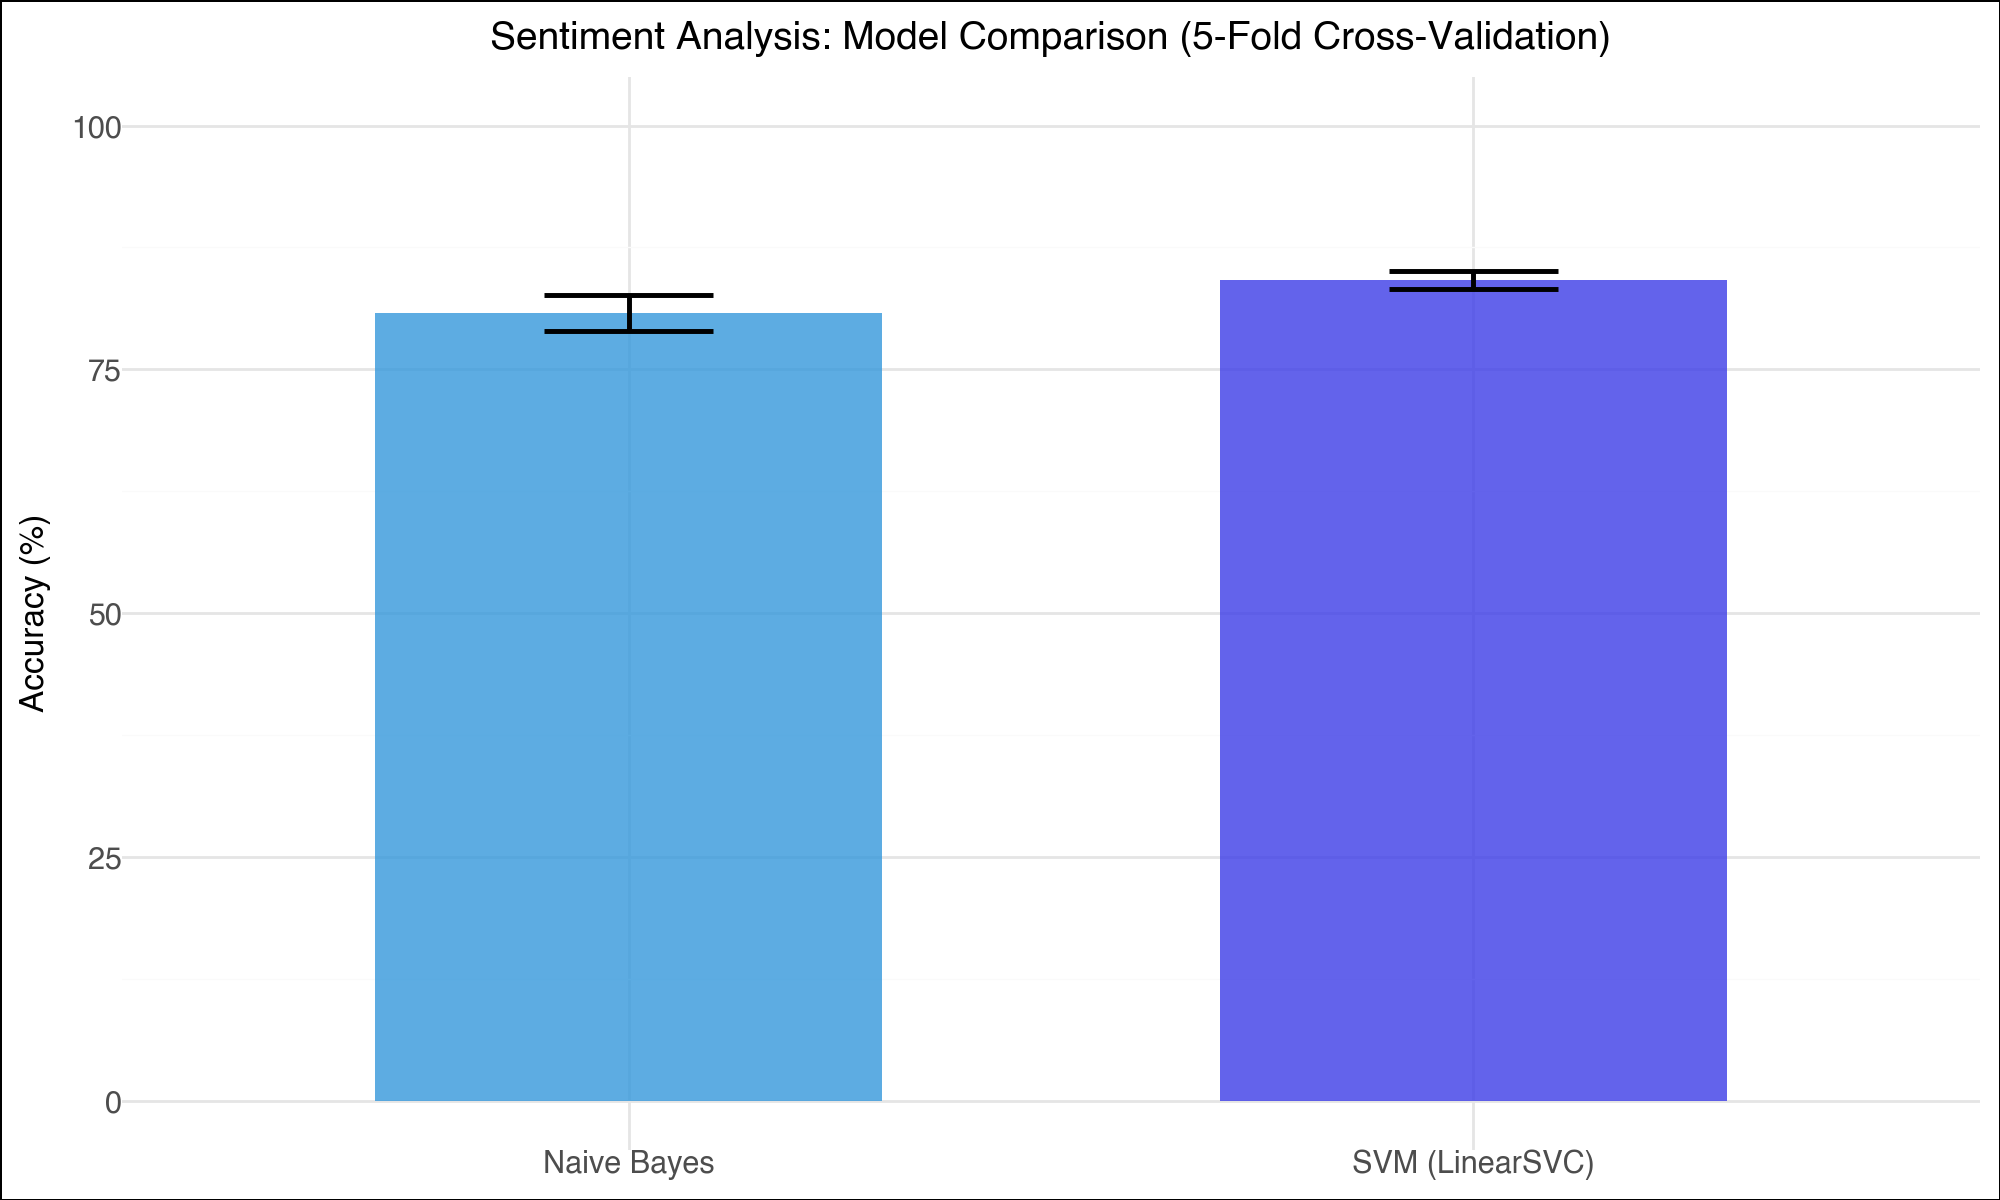

In [70]:
# Compare model accuracy
import pandas as pd
from plotnine import *

# Get the M and SD values from the above CV steps
res = pd.DataFrame({
    'Model': ['Naive Bayes', 'SVM (LinearSVC)'],
    'Mean_Accuracy': [mean_accuracy * 100, mean_cv_svm * 100],
    'Std_Accuracy': [std_accuracy * 100, std_cv_svm * 100]
})

# Create the plot
plot = (
    ggplot(res, aes(x='Model', y='Mean_Accuracy', fill='Model')) +
    geom_col(alpha=0.8, width=0.6) +
    geom_errorbar(
        aes(ymin='Mean_Accuracy - Std_Accuracy', 
            ymax='Mean_Accuracy + Std_Accuracy'),
        width=0.2,
        size=1
    ) +
    scale_fill_manual(values=['#3498db', "#3c3ce7"]) +
    labs(
        title='Sentiment Analysis: Model Comparison (5-Fold Cross-Validation)',
        x='',
        y='Accuracy (%)'
    ) +
    ylim(0, 100) + # Display up to 100% accuracy
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, weight='bold', ha='center'),
        axis_text=element_text(size=11),
        axis_title=element_text(size=12, weight='bold'),
        legend_position='none',
        figure_size=(10, 6),
        plot_background=element_rect(fill='white'),
        panel_background=element_rect(fill='white')
    )
)

# Display the plot
display(plot)